# Emulation of Waves
## Weather Typing + Probabilistic - Copula Model
## Predictor- Load Weather Types

In [1]:
from bluemath_tk.core.io import load_model

daily_xwt = load_model("outputs/dwt_model_aveiro.pkl")
dwts_to_fit = daily_xwt.steps.get("pca").pcs.kma_bmus.to_dataset(name="bmus")
dwts_to_fit["cenEOFs"] = (
    ("n_clusters", "n_features"),
    daily_xwt.steps.get("kma").kma.cluster_centers_,
)
dwts_to_fit

<xarray.Dataset> Size: 250kB
Dimensions:  (time: 19684, n_clusters: 36, n_features: 97)
Coordinates:
  * time     (time) datetime64[s] 157kB 1970-01-01 1970-01-02 ... 2023-11-22
Dimensions without coordinates: n_clusters, n_features
Data variables:
    bmus     (time) int32 79kB 15 15 15 10 10 10 10 10 ... 6 7 16 15 15 6 24 24
    cenEOFs  (n_clusters, n_features) float32 14kB 17.83 -2.286 ... -0.05462

## Predictand- Load regional/local wave data
### significant wave height, peak period, mean wave direction

In [2]:
import xarray as xr

waves = (
    xr.open_dataset("data/waves_EF_daily.nc")
    .sel(time=dwts_to_fit.time, method="nearest", tolerance="1H")
    .rename({"swh": "bulk_Hs", "pp1d": "bulk_Tp", "mwd": "bulk_Dir"})
)
waves["bmus"] = (("time"), dwts_to_fit["bmus"].values)
waves

<xarray.Dataset> Size: 866kB
Dimensions:    (time: 19684)
Coordinates:
    longitude  float32 4B ...
    latitude   float32 4B ...
  * time       (time) datetime64[ns] 157kB 1970-01-01 1970-01-02 ... 2023-11-22
Data variables:
    bulk_Hs    (time) float64 157kB ...
    bulk_Tp    (time) float64 157kB ...
    bulk_Dir   (time) float64 157kB ...
    EF         (time) float64 157kB ...
    bmus       (time) int32 79kB 15 15 15 10 10 10 10 10 ... 7 16 15 15 6 24 24
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-24 23:51:43 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

## Predictand to Predictor- Model
## Probabilistic - Copula Model

In [ ]:
from bluemath_tk.teslakit.climate_emulator import Climate_Emulator

ce = Climate_Emulator(
    "/workspaces/BlueMath/climate_services/probabilistic/MUSCLE_Aveiro/outputs/emulator"
)

config = {
    "waves_families": ["bulk"],
    "distribution": [],
    "do_chromosomes": False,
}
ce.FitExtremes(KMA=dwts_to_fit, WVS=waves, config=config, proxy="EF")

Waves Families: ['bulk']
Extra Variables: []
GEV distribution: ['bulk_Hs', 'bulk_Tp']
Empirical distribution: ['bulk_Dir']
Weibull distribution: []
Do chromosomes combinations: False
Max. Storms PROXY: EF


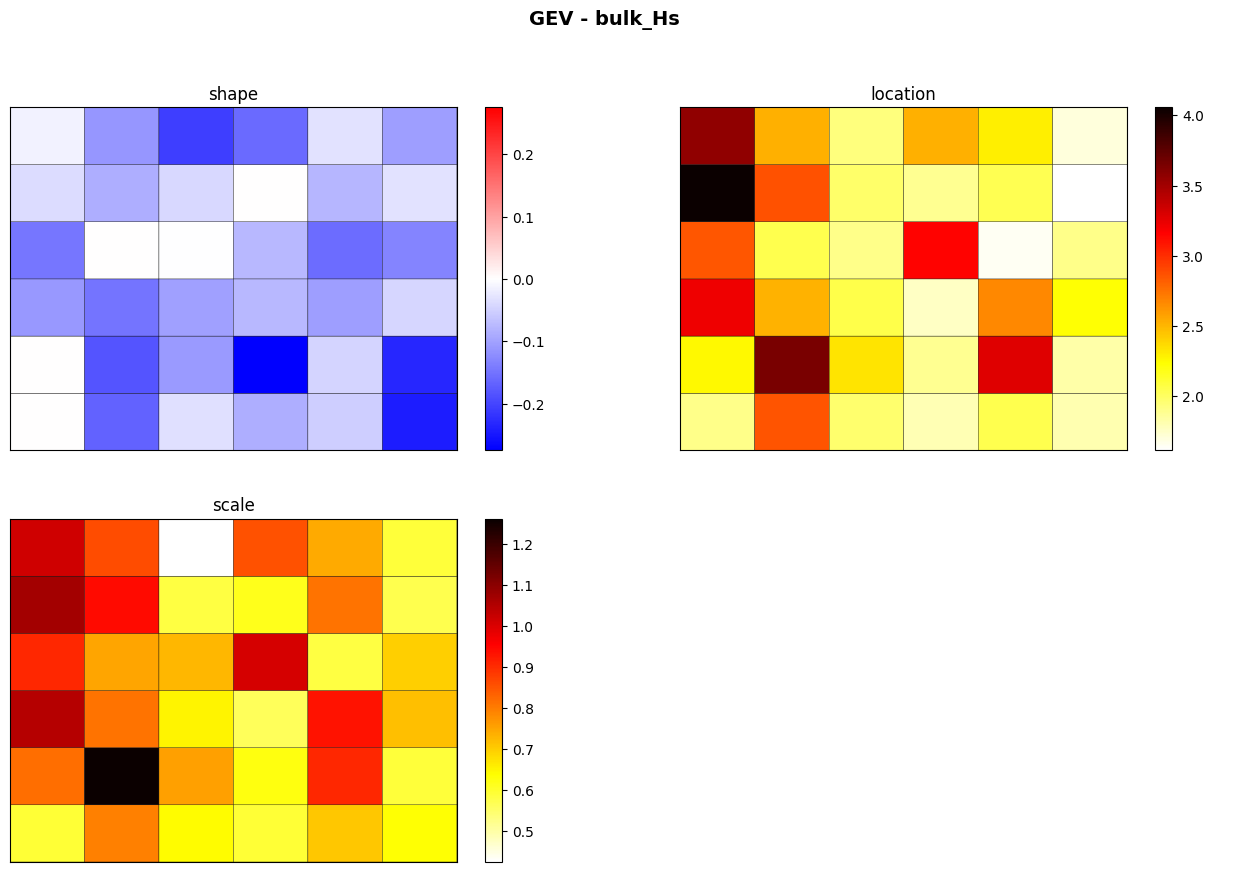

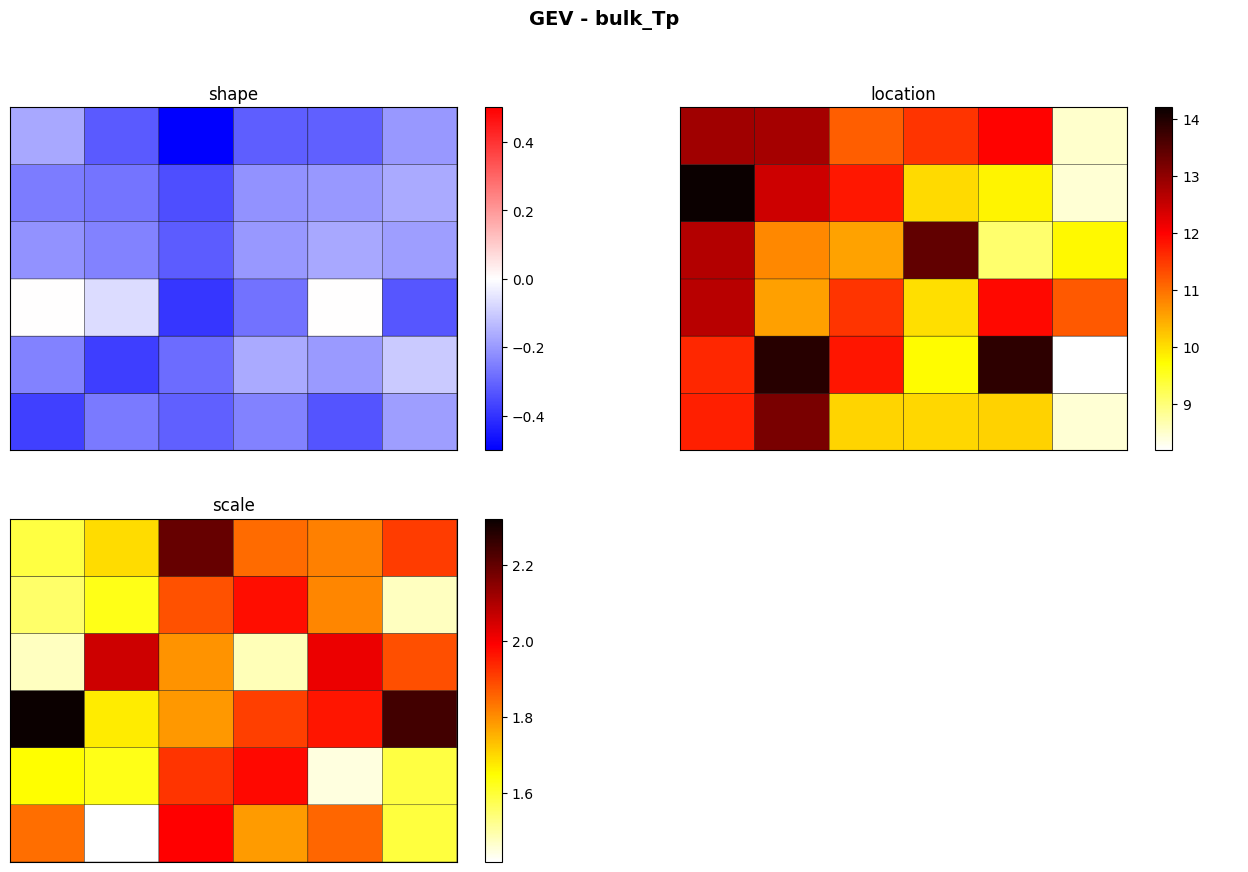

In [4]:
# Fit report figures

ce.Report_Fit(vns_GEV=["Hs", "Tp"], plot_chrom=False, plot_sigma=False);

## Climate Emulator
### Emulation of Weather Types + Emulation of Waves

In [5]:
# Load simulated DWTs

simulated_dwts = xr.open_dataset("outputs/xds_output.nc")
simulated_dwts

<xarray.Dataset> Size: 2MB
Dimensions:      (time: 36891, n_sim: 5)
Coordinates:
  * time         (time) datetime64[ns] 295kB 1999-01-01 ... 2100-01-01
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) int64 1MB ...
    ofbmus_sims  (time, n_sim) bool 184kB ...

In [6]:
simulated_waves = ce.Simulate_Waves(simulated_dwts.isel(n_sim=0), 1)
simulated_waves

C.E: Sim. Waves: 100%|██████████| 11776/11776 [00:41<00:00, 280.86it/s]


<xarray.Dataset> Size: 471kB
Dimensions:   (n_sim: 1, time: 11776)
Coordinates:
  * time      (time) datetime64[ns] 94kB 1999-01-01 1999-01-03 ... 2100-01-01
Dimensions without coordinates: n_sim
Data variables:
    DWT       (n_sim, time) int64 94kB 15 10 1 3 17 30 18 ... 10 25 7 29 21 17
    bulk_Hs   (n_sim, time) float64 94kB 1.544 2.518 3.99 ... 4.283 2.287 1.4
    bulk_Tp   (n_sim, time) float64 94kB 12.51 7.73 12.24 ... 16.47 11.45 13.52
    bulk_Dir  (n_sim, time) float64 94kB 341.9 275.4 314.1 ... 339.9 308.9 293.0

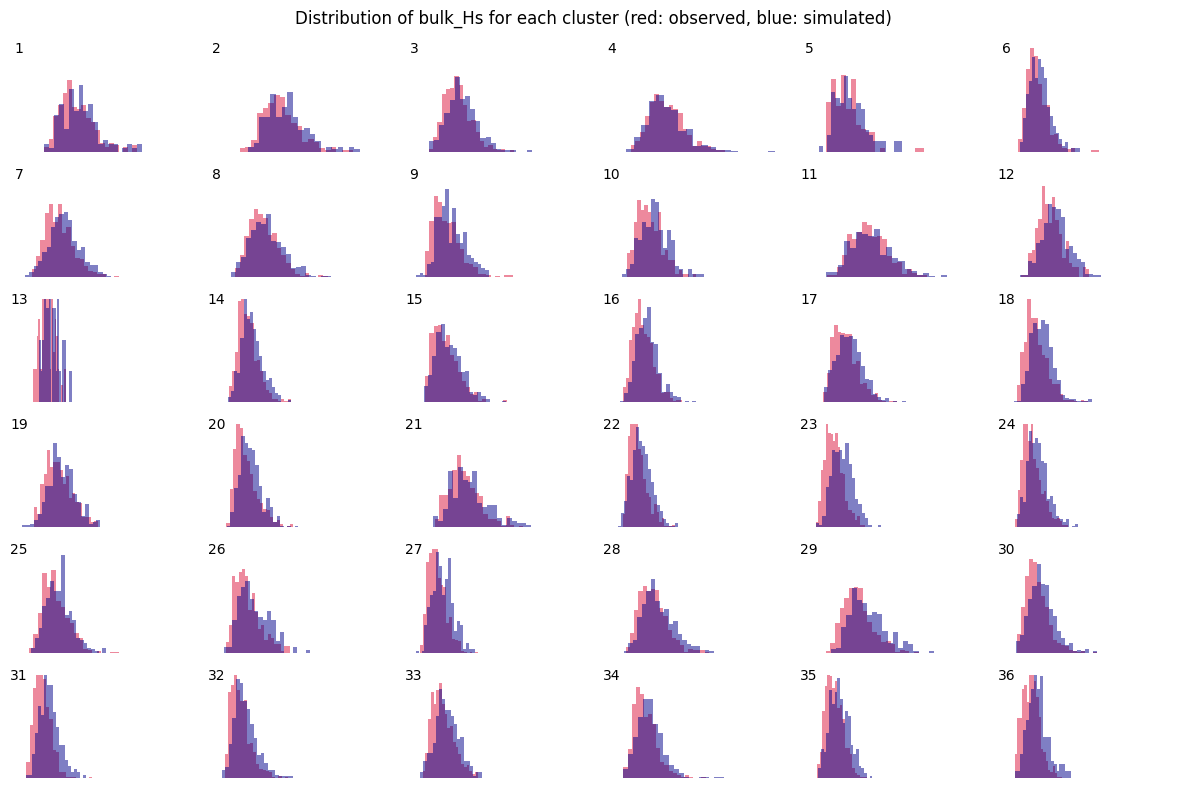

In [7]:
import matplotlib.pyplot as plt

var_to_plot = "bulk_Hs"

fig, axes = plt.subplots(6, 6, figsize=(12, 8), sharex=True, sharey=True)
for cluster, ax in enumerate(axes.flatten()):
    waves.isel(time=waves.groupby("bmus").groups.get(cluster+1))[var_to_plot].plot.hist(
        ax=ax, density=True, alpha=0.5, bins=20, color="crimson"
    )
    simulated_waves.isel(time=simulated_waves.groupby("DWT").groups.get(cluster+1))[var_to_plot].plot.hist(
        ax=ax, density=True, alpha=0.5, bins=20, color="darkblue"
    )
    ax.axis("off")
    ax.text(0, 0.7, f"{cluster+1}", fontsize=10, ha="center", va="center")
    ax.set_ylim(0, 0.7)
    fig.suptitle(
        f"Distribution of {var_to_plot} for each cluster (red: observed, blue: simulated)",
        fontsize=12,
        ha="center",
        va="top",
    )
plt.subplots_adjust(top=0.9)
plt.tight_layout()

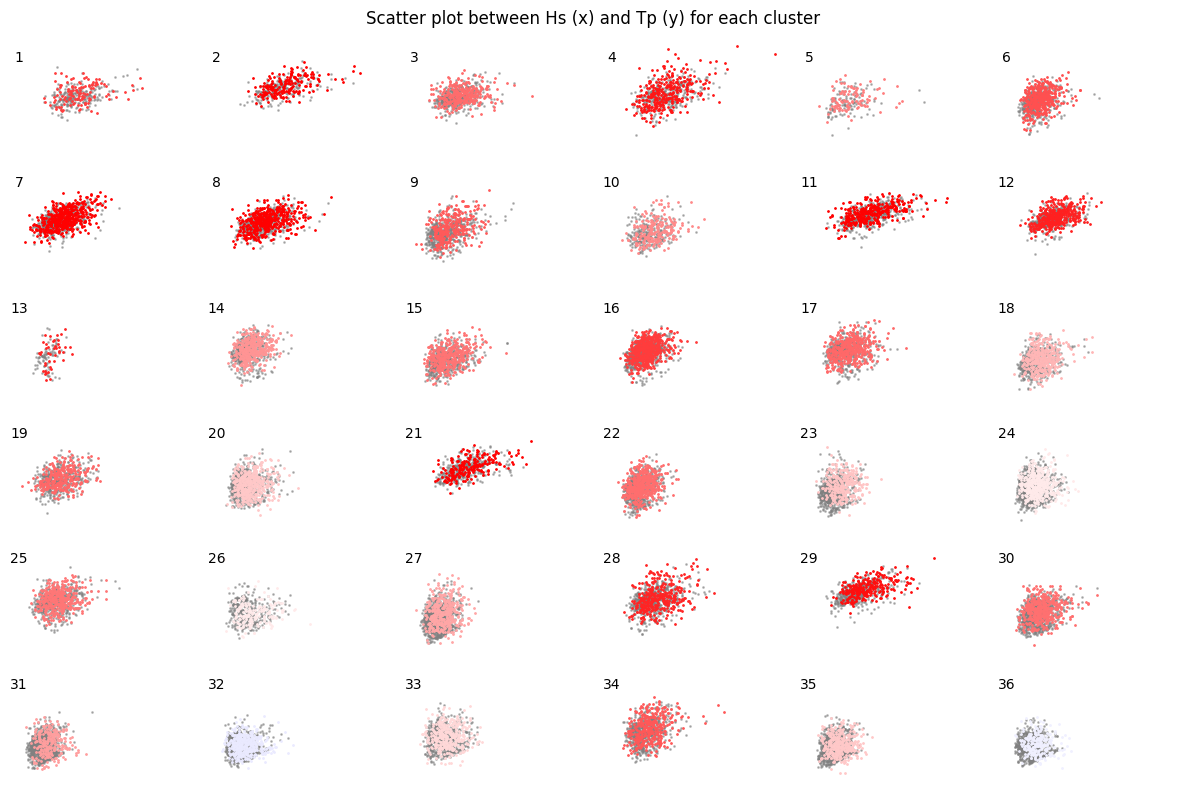

In [8]:
import numpy as np
import matplotlib.colors as mcolors

cmap = plt.cm.get_cmap('bwr')
norm = mcolors.Normalize(vmin=-0.5, vmax=0.5)
# Get correlation values
corr_values = np.array([ce.sigma[cluster][0]["corr"][0, 1] for cluster in range(1, 37)])
# Get colors for the correlation values
corr_values_colors = [cmap(norm(value)) for value in corr_values]
# Plot the correlation values
fig, axes = plt.subplots(6, 6, figsize=(12, 8), sharex=True, sharey=True)
for cluster, ax in enumerate(axes.flatten()):
    waves.isel(time=waves.groupby("bmus").groups.get(cluster+1)).plot.scatter(
        ax=ax, x="bulk_Hs", y="bulk_Tp", s=1, color="grey", alpha=0.5
    )
    simulated_waves.isel(time=simulated_waves.groupby("DWT").groups.get(cluster+1)).plot.scatter(
        ax=ax, x="bulk_Hs", y="bulk_Tp", s=1, color=corr_values_colors[cluster]
    )
    ax.axis("off")
    ax.text(0, 20, f"{cluster+1}", fontsize=10, ha="center", va="center")
fig.suptitle(
    f"Scatter plot between Hs (x) and Tp (y) for each cluster",
    fontsize=12,
    ha="center",
    va="top",
)
plt.subplots_adjust(top=0.9)
plt.tight_layout()